# Explaining Titanic model using SHAP

In [1]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

import shap
shap.initjs()

# Simple feature engineering
Download the data from [https://www.kaggle.com/c/titanic/data](https://www.kaggle.com/c/titanic/data) and place it in the data folder where this notebook is.

In [3]:
df = pd.read_csv('data/train.csv')

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
df[df['Age'].isnull()].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q


In [7]:
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)

In [8]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [9]:
# One-hot encode Embraked
df['Embarked'].fillna('S', inplace = True)
df_embarked = pd.get_dummies(df['Embarked'], prefix='Embarked', drop_first = True)
df_embarked.head(2)

,Embarked_Q,Embarked_S
0,0,1
1,0,0


In [10]:
df = pd.concat([df, df_embarked], axis=1).drop(['Embarked'], axis=1)
# One-hot encode Sex
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,0,1
1,1,1,1,38.0,1,0,71.2833,0,0


In [11]:
# Impute age with Pclass and Sex
dtree = DecisionTreeRegressor(max_depth = 2)
df_age = df[~df.Age.isnull()]
df_age_null = df[df.Age.isnull()]
X_train = df_age[['Pclass', 'Sex']]
y_train = df_age['Age']
dtree.fit(X_train, y_train)
X_test = df_age_null[['Pclass', 'Sex']]

In [12]:
df.loc[df.Age.isnull(), 'Age'] = dtree.predict(X_test)

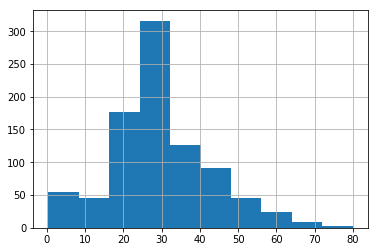

In [13]:
df['Age'].hist()

In [14]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,0,1
1,1,1,1,38.0,1,0,71.2833,0,0
2,1,3,1,26.0,0,0,7.9250,0,1
3,1,1,1,35.0,1,0,53.1000,0,1
4,0,3,0,35.0,0,0,8.0500,0,1


In [15]:
X = df.drop(['Survived'], axis=1)
y = df['Survived']

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=7)

# Interpreting models using SHAP
## Logistic regression

In [17]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_valid, y_valid)

0.7597765363128491

In [18]:
f = lambda x: lr.predict_proba(x)[:,1]
med = X_train.mean().values.reshape((1,X_train.shape[1]))
explainer = shap.KernelExplainer(f, med)

In [19]:
shap_values = explainer.shap_values(X_train, nsamples=1000);
shap.force_plot(explainer.expected_value, shap_values, X_train)

100%|██████████| 712/712 [00:05<00:00, 141.69it/s]


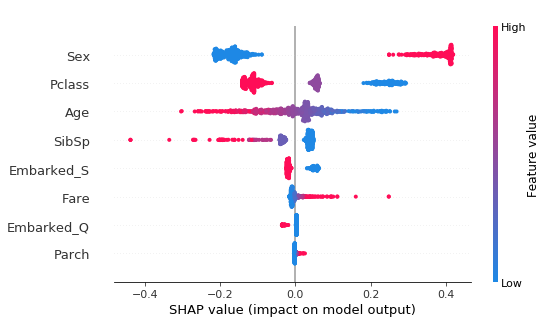

In [20]:
shap.summary_plot(shap_values, X_train, show=False)
plt.savefig('SHAPSummary_LR.png', bbox_inches="tight")

In [21]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

## Linear regression

In [22]:
linear = LinearRegression()
linear.fit(X_train, y_train)
accuracy_score(y_valid, linear.predict(X_valid) > 0.5)

0.7541899441340782

100%|██████████| 712/712 [00:04<00:00, 158.50it/s]


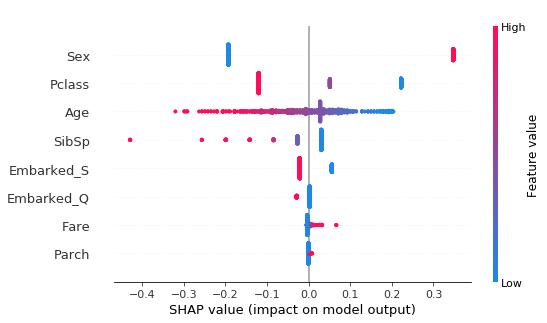

In [23]:
f = lambda x: linear.predict(x)
explainer = shap.KernelExplainer(f, med)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [24]:
np.set_printoptions(precision=3)
np.r_[(X_train.iloc[0,:].values - med) * linear.coef_, [shap_values[0,:]]]

array([[-0.12 ,  0.347,  0.192,  0.031,  0.001, -0.003,  0.003, -0.021],
       [-0.12 ,  0.347,  0.192,  0.031,  0.001, -0.003,  0.003, -0.021]])

As expected, the SHAP values and the (feature value) * (coefficient from linear regression) are the same

## KNN

In [25]:
knn = KNeighborsClassifier()
params_search = {'n_neighbors': [3, 4, 5, 6, 7]}
grid_clf_acc = GridSearchCV(knn, params_search, cv=10, n_jobs=-1, verbose=True)
grid_clf_acc.fit(X_train, y_train)
print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
print(grid_clf_acc.cv_results_['mean_test_score'])

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Grid best parameter (max. accuracy):  {'n_neighbors': 3}
[0.711 0.708 0.699 0.706 0.701]


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


100%|██████████| 712/712 [00:05<00:00, 133.09it/s]


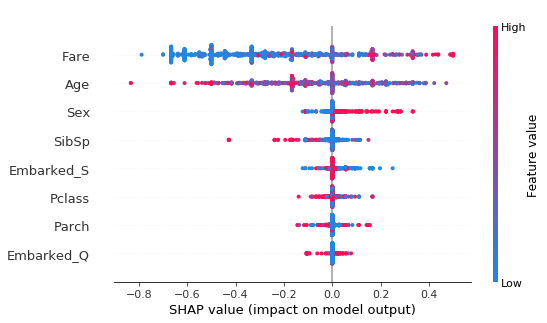

In [26]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
# Shap
f = lambda x: knn.predict_proba(x)[:,1]
explainer = shap.KernelExplainer(f, med)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, show = False)
plt.savefig('SHAPSummary_KNN.png', bbox_inches="tight")

In [27]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

## XGBoost

In [28]:
xgb = XGBClassifier(max_depth=5, learning_rate=0.1)
params_search = {'n_estimators': [10, 20, 30, 40]}
grid_clf_acc = GridSearchCV(xgb, params_search, cv=10, n_jobs=-1, verbose=True)
grid_clf_acc.fit(X_train, y_train)
print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
grid_clf_acc.cv_results_['mean_test_score']

Fitting 10 folds for each of 4 candidates, totalling 40 fits


/Users/meichenlu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/meichenlu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/meichenlu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/meichenlu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/Users/meichenlu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/meichenlu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/meichenlu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/meichenlu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/Users/meichenlu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/meichenlu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/meichenlu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/meichenlu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

Grid best parameter (max. accuracy):  {'n_estimators': 10}


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.5s finished


array([0.838, 0.836, 0.838, 0.837])

In [29]:
xgb = XGBClassifier(max_depth=5, n_estimators = 30, learning_rate=0.1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=30,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

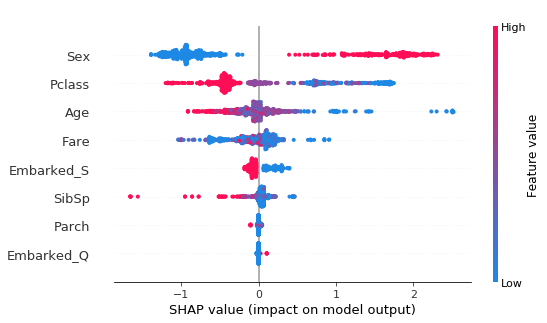

In [30]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, show = False)
plt.savefig('SHAPSummary_XGB.png', bbox_inches="tight")

In [31]:
shap.force_plot(explainer.expected_value, shap_values, X_train)

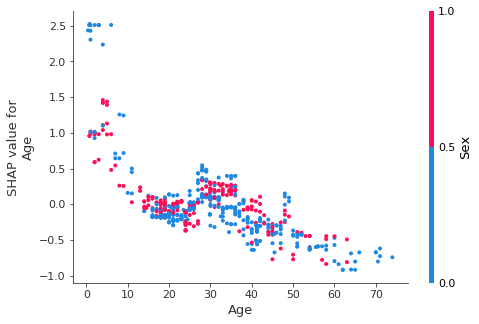

In [32]:
shap.dependence_plot("Age", shap_values, X_train, show = False)
plt.savefig('SHAPAge_XGB.png', bbox_inches="tight")

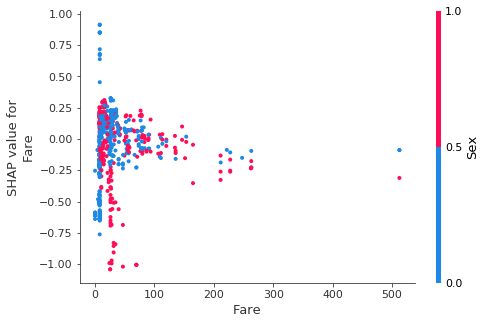

In [33]:
shap.dependence_plot("Fare", shap_values, X_train)

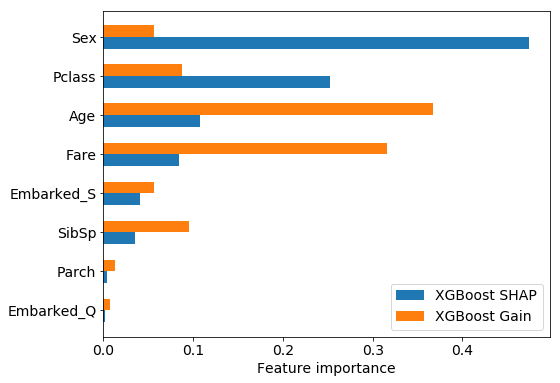

In [34]:
rcParams['font.size'] = 14
feature_names = X_train.columns.values
n_features = len(feature_names)
shap_per_feature = np.mean(np.abs(shap_values), axis = 0)
shap_per_feature = shap_per_feature/(np.sum(shap_per_feature))
idx_sorted = shap_per_feature.argsort()
fig = plt.figure(figsize=(8, 6)) 
plt.barh(np.arange(n_features) - 0.15, shap_per_feature[idx_sorted], 0.3)
plt.barh(np.arange(n_features) + 0.15, xgb.feature_importances_[idx_sorted], 0.3)
plt.xlabel("Feature importance")
plt.yticks(np.arange(n_features), feature_names[idx_sorted])
plt.legend(['XGBoost SHAP','XGBoost Gain'], loc = 'lower right')
plt.savefig('FeatureImportance_XGB.png', bbox_inches="tight")

In [35]:
shap_interaction_values = explainer.shap_interaction_values(X_train)

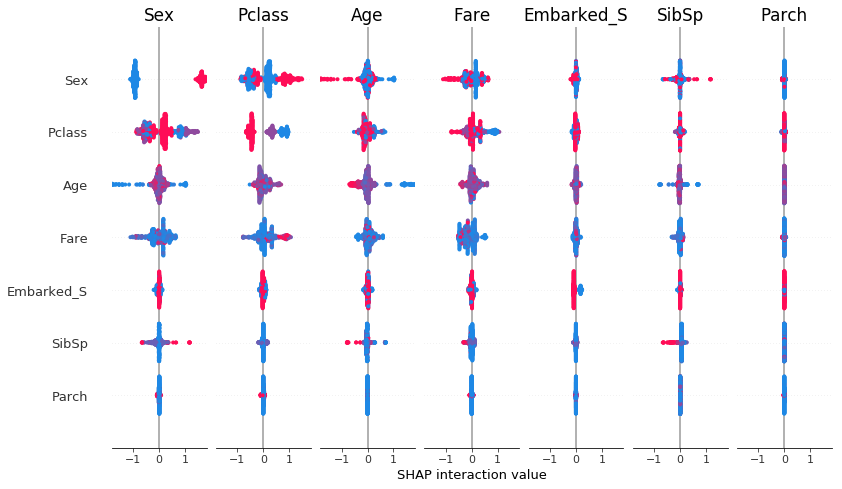

In [36]:
shap.summary_plot(shap_interaction_values, X_train)

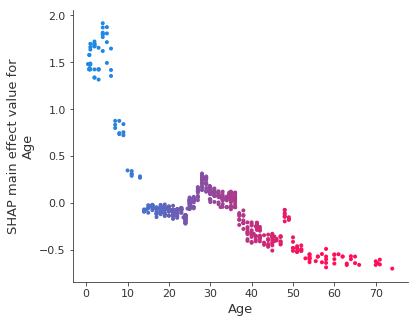

In [37]:
shap.dependence_plot(
    ("Age", "Age"),
    shap_interaction_values, X_train,
    display_features=X_train,
    show = False
)
plt.savefig('SHAP_AgeMain_XGB.png', bbox_inches="tight")

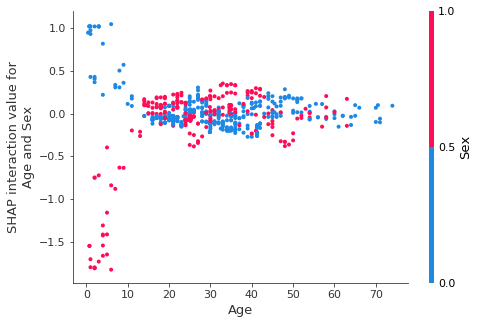

In [38]:
shap.dependence_plot(
    ("Age", "Sex"),
    shap_interaction_values, X_train,
    display_features=X_train,
    show = False
)
plt.savefig('SHAP_AgeSex_XGB.png', bbox_inches="tight")

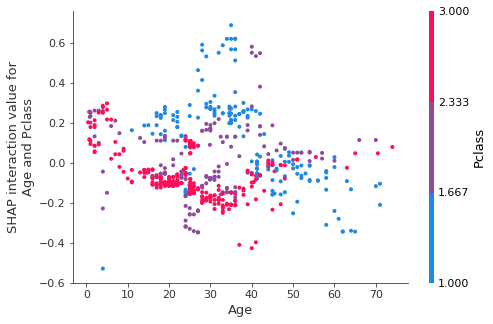

In [39]:
shap.dependence_plot(
    ("Age", "Pclass"),
    shap_interaction_values, X_train,
    display_features=X_train,
)